In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import cv2
import os
import numpy as np

import sys
import random
import math
import skimage.io
import matplotlib

import time
import argparse
import torch
from PIL import Image

Using TensorFlow backend.


image

In [2]:
train_path = './image/train/'

I = cv2.imread(train_path + 'humans/' + 'human01-00.png')
print (I.shape)

(300, 300, 3)


In [3]:
def ReFileName(l,dirPath):
    for file in os.listdir(dirPath):
        if os.path.isfile(os.path.join(dirPath, file)) == True:
            c= os.path.basename(file)
            name = dirPath + '\\' + c
            img = cv2.imread(name)
            img=cv2.resize(img,(100,100))#使尺寸大小一样
            l.append(img)

In [4]:
train_human_Path = "./image/train/humans"
train = []
ReFileName(train,train_human_Path)
label=[[0] for i in range(len(train))]
num_human = len(train)

In [5]:
train_horse_Path = "./image/train/horses"
ReFileName(train,train_horse_Path)
num_horse = len(train) - num_human
for i in range (num_horse):
    label.append([1])

In [6]:
train = np.array(train)
label = np.array(label)

print("x trian shape ", train.shape)
print("y train shape ", label.shape)

x trian shape  (1027, 100, 100, 3)
y train shape  (1027, 1)


In [7]:
test_human_Path = "./image/test/humans"
test = []
ReFileName(test,test_human_Path)
ytest=[[0] for i in range(len(test))]
num_human = len(test)

test_horse_Path = "./image/test/horses"
ReFileName(test,test_horse_Path)
num_horse = len(test) - num_human
for i in range (num_horse):
    ytest.append([1])
test = np.array(test)
ytest = np.array(ytest)

print("x test shape ", test.shape)
print("y test shape ", ytest.shape)

x test shape  (256, 100, 100, 3)
y test shape  (256, 1)


In [8]:
train, test = train / 255, test / 255

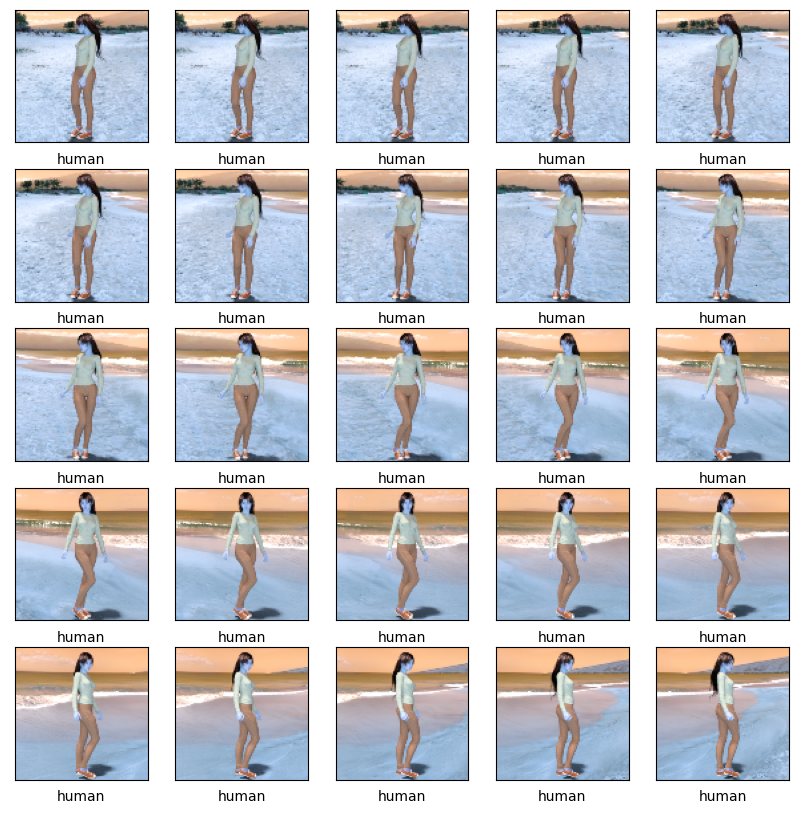

In [9]:
name = ['human','horse']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(name[label[i][0]])
plt.show()

CNN

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 28224)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [11]:
train.shape

(1027, 100, 100, 3)

In [12]:
label.shape

(1027, 1)

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train, label, epochs=10, 
                    validation_data=(test, ytest))

Epoch 1/10
33/33 [==============================] - 4s 17ms/step - loss: 0.5417 - accuracy: 0.7585 - val_loss: 2.0951 - val_accuracy: 0.6797
Epoch 2/10
33/33 [==============================] - 0s 9ms/step - loss: 0.1117 - accuracy: 0.9611 - val_loss: 1.7772 - val_accuracy: 0.7969
Epoch 3/10
33/33 [==============================] - 0s 9ms/step - loss: 0.0502 - accuracy: 0.9815 - val_loss: 1.4962 - val_accuracy: 0.8320
Epoch 4/10
33/33 [==============================] - 0s 9ms/step - loss: 0.0232 - accuracy: 0.9932 - val_loss: 2.1700 - val_accuracy: 0.7969
Epoch 5/10
33/33 [==============================] - 0s 9ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.7603 - val_accuracy: 0.7969
Epoch 6/10
33/33 [==============================] - 0s 9ms/step - loss: 9.4040e-04 - accuracy: 1.0000 - val_loss: 2.8439 - val_accuracy: 0.7930
Epoch 7/10
33/33 [==============================] - 0s 9ms/step - loss: 5.2987e-04 - accuracy: 1.0000 - val_loss: 2.8853 - val_accuracy: 0.7969
Epoch 8/10


In [14]:
def bboxIOU (bboxA, bboxB): 
    A_xmin = bboxA[0] 
    A_ymin = bboxA[1] 
    A_xmax = bboxA[2] 
    A_ymax = bboxA[3] 
    
    A_width = A_xmax - A_xmin 
    A_height = A_ymax - A_ymin 
    
    B_xmin = bboxB[0] 
    B_ymin = bboxB[1] 
    B_xmax = bboxB[2] 
    B_ymax = bboxB[3] 
    
    B_width = B_xmax - B_xmin 
    B_height = B_ymax - B_ymin 
    
    xmin = min(A_xmin, B_xmin) 
    ymin = min(A_ymin, B_ymin) 
    xmax = max(A_xmax, B_xmax) 
    ymax = max(A_ymax, B_ymax) 
    
    A_width_and = (A_width + B_width) - (xmax - xmin) # 宽的交集 
    A_height_and = (A_height + B_height) - (ymax - ymin) # 高的交集 
    
    if ( A_width_and <= 0.0001 or A_height_and <= 0.0001): 
        return 0 
    
    area_and = (A_width_and * A_height_and) 
    area_or = (A_width * A_height) + (B_width * B_height) 
    IOU = area_and / (area_or - area_and) 
    
    return IOU

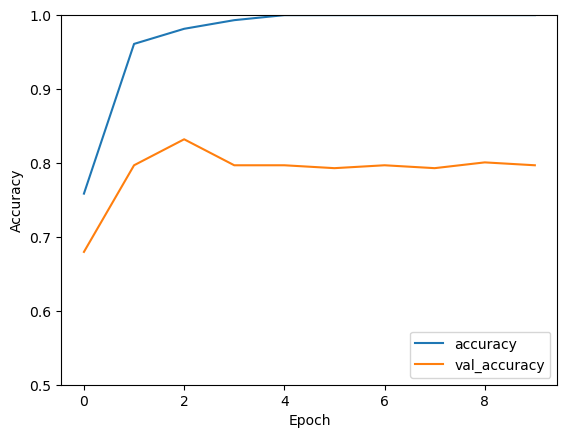

8/8 - 0s - loss: 2.9608 - accuracy: 0.7969


In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test, ytest, verbose=2)

Yolo

In [16]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s') 

Using cache found in C:\Users\Administrator/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [17]:
%run detect.py --weights yolov5s.pt --source test.png --project res --name test

detect: weights=['yolov5s.pt'], source=test.png, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=res, name=test, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\test.png: 640x640 1 person, 192.0ms
Speed: 1.0ms pre-process, 192.0ms inference, 2.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to res\test


In [18]:
dirPath = "./image/test/humans"
resPath = "./res/test/humans"

for file in os.listdir(dirPath):
    if os.path.isfile(os.path.join(dirPath, file)) == True:
        c= os.path.basename(file)
        name = dirPath + '\\' + c
        %run detect.py --weights yolov5s.pt --source $name --project $resPath --name $c

detect: weights=['yolov5s.pt'], source=./image/test/humans\valhuman01-00.png, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=./res/test/humans, name=valhuman01-00.png, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\image\test\humans\valhuman01-00.png: 640x640 1 person, 192.0ms
Speed: 1.0ms pre-process, 192.0ms inference, 2.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to res\test\humans\valhuman01-00.png
detect: weights=['yolov5s.pt'], source=./image/test/humans

YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\image\test\humans\valhuman01-08.png: 640x640 1 person, 211.0ms
Speed: 1.0ms pre-process, 211.0ms inference, 3.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to res\test\humans\valhuman01-08.png
detect: weights=['yolov5s.pt'], source=./image/test/humans\valhuman01-09.png, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=./res/test/humans, name=valhuman01-09.png, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusi

YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\image\test\humans\valhuman01-17.png: 640x640 1 person, 189.0ms
Speed: 1.0ms pre-process, 189.0ms inference, 2.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to res\test\humans\valhuman01-17.png
detect: weights=['yolov5s.pt'], source=./image/test/humans\valhuman01-18.png, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=./res/test/humans, name=valhuman01-18.png, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusi

YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\image\test\humans\valhuman02-01.png: 640x640 1 person, 189.1ms
Speed: 0.0ms pre-process, 189.1ms inference, 2.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to res\test\humans\valhuman02-01.png
detect: weights=['yolov5s.pt'], source=./image/test/humans\valhuman02-02.png, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=./res/test/humans, name=valhuman02-02.png, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusi

YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\image\test\humans\valhuman02-10.png: 640x640 1 person, 192.0ms
Speed: 1.0ms pre-process, 192.0ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to res\test\humans\valhuman02-10.png
detect: weights=['yolov5s.pt'], source=./image/test/humans\valhuman02-11.png, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=./res/test/humans, name=valhuman02-11.png, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusi

YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\image\test\humans\valhuman02-19.png: 640x640 1 person, 181.5ms
Speed: 1.0ms pre-process, 181.5ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to res\test\humans\valhuman02-19.png
detect: weights=['yolov5s.pt'], source=./image/test/humans\valhuman02-20.png, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=./res/test/humans, name=valhuman02-20.png, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusi

YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\image\test\humans\valhuman03-03.png: 640x640 1 person, 180.0ms
Speed: 1.0ms pre-process, 180.0ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to res\test\humans\valhuman03-03.png
detect: weights=['yolov5s.pt'], source=./image/test/humans\valhuman03-04.png, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=./res/test/humans, name=valhuman03-04.png, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusi

YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\image\test\humans\valhuman03-12.png: 640x640 1 person, 1 tie, 190.0ms
Speed: 0.0ms pre-process, 190.0ms inference, 3.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to res\test\humans\valhuman03-12.png
detect: weights=['yolov5s.pt'], source=./image/test/humans\valhuman03-13.png, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=./res/test/humans, name=valhuman03-13.png, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CP

YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\image\test\humans\valhuman03-21.png: 640x640 1 person, 193.5ms
Speed: 1.5ms pre-process, 193.5ms inference, 2.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to res\test\humans\valhuman03-21.png
detect: weights=['yolov5s.pt'], source=./image/test/humans\valhuman03-22.png, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=./res/test/humans, name=valhuman03-22.png, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusi

YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\image\test\humans\valhuman04-05.png: 640x640 1 person, 194.0ms
Speed: 1.0ms pre-process, 194.0ms inference, 2.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to res\test\humans\valhuman04-05.png
detect: weights=['yolov5s.pt'], source=./image/test/humans\valhuman04-06.png, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=./res/test/humans, name=valhuman04-06.png, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusi

YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\image\test\humans\valhuman04-14.png: 640x640 1 person, 187.6ms
Speed: 1.0ms pre-process, 187.6ms inference, 2.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to res\test\humans\valhuman04-14.png
detect: weights=['yolov5s.pt'], source=./image/test/humans\valhuman04-15.png, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=./res/test/humans, name=valhuman04-15.png, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusi

YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\image\test\humans\valhuman04-23.png: 640x640 1 person, 189.0ms
Speed: 1.0ms pre-process, 189.0ms inference, 2.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to res\test\humans\valhuman04-23.png
detect: weights=['yolov5s.pt'], source=./image/test/humans\valhuman04-24.png, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=./res/test/humans, name=valhuman04-24.png, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusi

YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\image\test\humans\valhuman05-07.png: 640x640 1 person, 199.5ms
Speed: 0.0ms pre-process, 199.5ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to res\test\humans\valhuman05-07.png
detect: weights=['yolov5s.pt'], source=./image/test/humans\valhuman05-08.png, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=./res/test/humans, name=valhuman05-08.png, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusi

YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\image\test\humans\valhuman05-16.png: 640x640 1 person, 184.0ms
Speed: 0.0ms pre-process, 184.0ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to res\test\humans\valhuman05-16.png
detect: weights=['yolov5s.pt'], source=./image/test/humans\valhuman05-17.png, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=./res/test/humans, name=valhuman05-17.png, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusi

YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\image\test\humans\valhuman05-25.png: 640x640 1 person, 182.1ms
Speed: 1.0ms pre-process, 182.1ms inference, 2.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to res\test\humans\valhuman05-25.png
detect: weights=['yolov5s.pt'], source=./image/test/humans\valhuman05-26.png, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=./res/test/humans, name=valhuman05-26.png, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusi

In [36]:
%run detect.py --weights yolov5s.pt --source Thorin_Input.mp4 --project video --name thorin --hide-labels

detect: weights=['yolov5s.pt'], source=Thorin_Input.mp4, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=video, name=thorin, exist_ok=False, line_thickness=3, hide_labels=True, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2022-12-13 Python-3.8.15 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
video 1/1 (1/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 124.5ms
video 1/1 (2/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 125.5ms
video 1/1 (3/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PR

video 1/1 (51/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 114.5ms
video 1/1 (52/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 110.5ms
video 1/1 (53/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 117.5ms
video 1/1 (54/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 113.6ms
video 1/1 (55/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 120.5ms
video 1/1 (56/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 110.5ms
video 1/1 (57/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and C

video 1/1 (105/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 116.5ms
video 1/1 (106/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 114.5ms
video 1/1 (107/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 115.5ms
video 1/1 (108/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 119.5ms
video 1/1 (109/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 119.5ms
video 1/1 (110/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 117.5ms
video 1/1 (111/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysi

video 1/1 (160/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 1 person, 109.5ms
video 1/1 (161/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 1 person, 112.5ms
video 1/1 (162/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 1 person, 117.0ms
video 1/1 (163/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 1 person, 118.5ms
video 1/1 (164/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 1 person, 109.5ms
video 1/1 (165/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 1 person, 111.5ms
video 1/1 (166/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and 

video 1/1 (214/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 4 persons, 123.0ms
video 1/1 (215/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 4 persons, 125.5ms
video 1/1 (216/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 3 persons, 120.5ms
video 1/1 (217/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 126.0ms
video 1/1 (218/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 117.5ms
video 1/1 (219/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 3 persons, 123.5ms
video 1/1 (220/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysi

video 1/1 (268/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 120.5ms
video 1/1 (269/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 121.5ms
video 1/1 (270/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 124.0ms
video 1/1 (271/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 119.5ms
video 1/1 (272/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 120.5ms
video 1/1 (273/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 119.0ms
video 1/1 (274/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 (no detections

video 1/1 (323/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 119.0ms
video 1/1 (324/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 121.5ms
video 1/1 (325/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 1 person, 122.5ms
video 1/1 (326/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 1 person, 120.0ms
video 1/1 (327/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 121.5ms
video 1/1 (328/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 1 person, 142.0ms
video 1/1 (329/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis a

video 1/1 (377/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 1 person, 157.0ms
video 1/1 (378/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 3 persons, 169.6ms
video 1/1 (379/379) C:\Users\Administrator\Desktop\Homework\INF573 - Image Analysis and Computer Vision\PRO\Thorin_Input.mp4: 384x640 2 persons, 124.5ms
Speed: 0.6ms pre-process, 122.2ms inference, 1.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to video\thorin2
